In [1]:
import numpy as np
from astropy import units as u
from astropy.table import Table, join
from astropy.io import fits
from astropy.nddata import CCDData
from astropy.stats import mad_std, sigma_clipped_stats
import ccdproc
from ccdproc import ImageFileCollection, Combiner, combine
import matplotlib.pyplot as plt
import photutils
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry 
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

In [3]:
from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture, EllipticalAnnulus

def geometry(x0, y0, sma, eps, pa):
    return EllipseGeometry(x0=x0, y0=y0, sma=sma, eps=eps,
                           pa=pa*np.pi/180.)


def aper(geometry):
    return EllipticalAperture((geometry.x0, geometry.y0), geometry.sma*(1 - geometry.eps),
                          geometry.sma,
                          geometry.pa)
def annulus(geometry, a_in, a_out, b_out, b_in):
    return EllipticalAnnulus((geometry.x0, geometry.y0), a_in*(geometry.sma*(1 - geometry.eps)), a_out*(geometry.sma*(1 - geometry.eps)),
                            b_out*geometry.sma, b_in*geometry.sma,
                            geometry.pa)

In [6]:
def ccd(filename):
    return CCDData.read(filename, units=u.adu)

NGC_4314_R = [ccd('./Data/Shifted/NGC4314_R_20210421_031038.fits'), ccd('./Data/Shifted/NGC4314_R_20210421_031944.fits'), ccd('./Data/Shifted/NGC4314_R_20210421_035346.fits')]
NGC_4314_V = [ccd('./Data/Shifted/NGC4314_V_20210421_055003.fits'), ccd('./Data/Shifted/NGC4314_V_20210421_060405.fits'), ccd('./Data/Shifted/NGC4314_V_20210421_062754.fits')]
NGC_4314_B = [ccd('./Data/Shifted/NGC4314_B_20210421_050806.fits'), ccd('./Data/Shifted/NGC4314_B_20210421_052258.fits'), ccd('./Data/Shifted/NGC4314_B_20210421_053639.fits')]
NGC_4314_H = [ccd('./Data/Shifted/NGC4314_Halpha_20210421_040933.fits'), ccd('./Data/Shifted/NGC4314_Halpha_20210421_044946.fits'), ccd('./Data/Shifted/NGC4314_Halpha_20210421_051244.fits')]

NGC_4314_R = Combiner(NGC_4314_R)
NGC_4314_R = NGC_4314_R.average_combine()
NGC_4314_B = Combiner(NGC_4314_B)
NGC_4314_B = NGC_4314_B.average_combine()
NGC_4314_V = Combiner(NGC_4314_V)
NGC_4314_V = NGC_4314_V.average_combine()
NGC_4314_H = Combiner(NGC_4314_H)
NGC_4314_H = NGC_4314_H.average_combine()

R4314data = np.asarray(NGC_4314_R)
_4314Rview = skimage.exposure.equalize_hist(R4314data)
H4314data = np.asarray(NGC_4314_H)
_4314Hview = skimage.exposure.equalize_hist(H4314data)

In [7]:
NGC_4651_R = [ccd('./Data/Shifted/NGC4651_R_20210421_070128.fits'), ccd('./Data/Shifted/NGC4651_R_20210421_071543.fits')]
NGC_4651_V = [ccd('./Data/Shifted/NGC4651_V_20210421_080600.fits'), ccd('./Data/Shifted/NGC4651_V_20210421_081927.fits')]
NGC_4651_H = [ccd('./Data/Shifted/NGC4651_Halpha_20210421_072853.fits'), ccd('./Data/Shifted/NGC4651_Halpha_20210421_074719.fits')]

NGC_4651_R = Combiner(NGC_4651_R)
NGC_4651_R = NGC_4651_R.average_combine()
NGC_4651_V = Combiner(NGC_4651_V)
NGC_4651_V = NGC_4651_V.average_combine()
NGC_4651_H = Combiner(NGC_4651_H)
NGC_4651_H = NGC_4651_H.average_combine()

R4651data = np.asarray(NGC_4651_R)
_4651Rview = skimage.exposure.equalize_hist(R4651data)
H4651data = np.asarray(NGC_4651_H)
_4651Hview = skimage.exposure.equalize_hist(H4651data)

In [8]:
M58_R = [ccd('./Data/Shifted/M58_R_20210513_041310.fits'), ccd('./Data/Shifted/M58_R_20210513_051246.fits'), ccd('./Data/Shifted/M58_R_20210513_052158.fits')]
M58_V = [ccd('./Data/Shifted/M58_V_20210513_053746.fits'), ccd('./Data/Shifted/M58_V_20210513_054641.fits'), ccd('./Data/Shifted/M58_V_20210513_055457.fits')]
M58_B = [ccd('./Data/Shifted/M58_B_20210513_060151.fits'), ccd('./Data/Shifted/M58_B_20210513_061003.fits'), ccd('./Data/Shifted/M58_B_20210513_0612358.fits')]
M58_H = [ccd('./Data/Shifted/M58_Halpha_20210513_042023.fits'), ccd('./Data/Shifted/M58_Halpha_20210513_042957.fits'),
         ccd('./Data/Shifted/M58_Halpha_20210513_044725.fits'), ccd('./Data/Shifted/M58_Halpha_20210513_045939.fits')]

M58_R = Combiner(M58_R)
M58_R = M58_R.average_combine()
M58_B = Combiner(M58_B)
M58_B = M58_B.average_combine()
M58_V = Combiner(M58_V)
M58_V = M58_V.average_combine()
M58_H = Combiner(M58_H)
M58_H = M58_H.average_combine()

M58Rdata = np.asarray(M58_R)
M58Rview = skimage.exposure.equalize_hist(M58Rdata)
M58Hdata = np.asarray(M58_H)
M58Hview = skimage.exposure.equalize_hist(M58Hdata)

In [9]:
M64_R = [ccd('./Data/Shifted/M64_R_20210516_032621.fits'), ccd('./Data/Shifted/M64_R_20210516_034316.fits')]
M64_V = [ccd('./Data/Shifted/M64_V_20210516_044202.fits'), ccd('./Data/Shifted/M64_V_20210516_045047.fits')]
M64_H = [ccd('./Data/Shifted/M64_Halpha_20210516_045916.fits'), ccd('./Data/Shifted/M64_Halpha_20210516_051244.fits'), ccd('./Data/Shifted/M64_Halpha_20210516_052622.fits')]

M64_R = Combiner(M64_R)
M64_R = M64_R.average_combine()
M64_V = Combiner(M64_V)
M64_V = M64_V.average_combine()
M64_H = Combiner(M64_H)
M64_H = M64_H.average_combine()

M64Rdata = np.asarray(M64_R)
M64Rview = skimage.exposure.equalize_hist(M64Rdata)
M64Hdata = np.asarray(M64_H)
M64Hview = skimage.exposure.equalize_hist(M64Hdata)

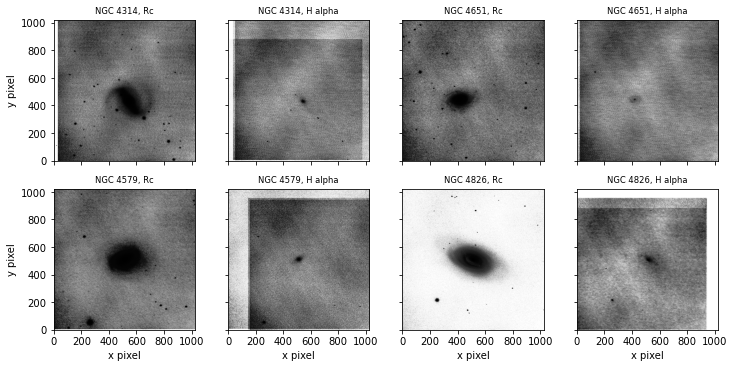

In [10]:
#Plot R and Halpha images
fig, ax = plt.subplots(2,4, figsize = (10, 5), sharex = True, sharey = True)
plt.tight_layout()
plt.rcParams.update({'font.size': 7})
ax[0,0].imshow(_4314Rview, cmap = 'Greys', origin = 'lower')
ax[0,0].set_title('NGC 4314, Rc')
ax[0,1].imshow(_4314Hview, cmap = 'Greys', origin = 'lower')
ax[0,1].set_title('NGC 4314, H alpha')

ax[0,2].imshow(_4651Rview, cmap = 'Greys', origin = 'lower')
ax[0,2].set_title('NGC 4651, Rc')
ax[0,3].imshow(_4651Hview, cmap = 'Greys', origin = 'lower')
ax[0,3].set_title('NGC 4651, H alpha')

ax[1,0].imshow(M58Rview, cmap = 'Greys', origin = 'lower')
ax[1,0].set_title('NGC 4579, Rc')
ax[1,1].imshow(M58Hview, cmap = 'Greys', origin = 'lower')
ax[1,1].set_title('NGC 4579, H alpha')


ax[1,2].imshow(M64Rview, cmap = 'Greys', origin = 'lower')
ax[1,2].set_title('NGC 4826, Rc')
ax[1,3].imshow(M64Hview, cmap = 'Greys', origin = 'lower')
ax[1,3].set_title('NGC 4826, H alpha')

ax[0,0].set_ylabel('y pixel')
ax[1,0].set_ylabel('y pixel')
for i in range(4):
    ax[1,i].set_xlabel('x pixel')

plt.savefig('r_and_h.png',bbox_inches='tight')

In [11]:
gain = 1.25 #convert from APU to e-

def photometry(data, aperture, annulus):
    '''Perform aperture photometry'''
    apers = [aperture, annulus]
    phot_table = aperture_photometry(data, apers)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'  # for consistent table output
    bkg_mean = phot_table['aperture_sum_1'] / annulus.area
    bkg_sum = bkg_mean * aperture.area
    final_sum = phot_table['aperture_sum_0'] - bkg_sum
    phot_table['residual_aperture_sum'] = final_sum
    phot_table['residual_aperture_sum'].info.format = '%.8g'  # for consistent table output
    return phot_table

def app_mag(intensity, c=23.5):
    '''Derive apparent magnitude from intensity'''
    return -2.5*np.log10(intensity*gain)+c

def abs_mag(app_mag, d):
    '''Derive absolute magnitude from apparent magnitude and distance'''
    return app_mag - 5*np.log10(d/(10*u.pc))

def luminosity(abs_mag):
    '''Convert absolute magnitude to luminosity'''
    return 10**((4.77-abs_mag)/2.5)*u.Lsun

def lum_to_ergs(luminosity):
    """Convert Lsun to ergs-1, useful separate for table"""
    return luminosity.to(u.erg*u.s**-1)

def SFR(luminosity):
    '''Estimate SFR from luminosity'''
    l = lum_to_ergs(luminosity)
    return l/(1.22*10**41*u.erg*u.s**-1) * u.Msun * u.year**-1

def find_SFR(intensity, distance, c=23.5):
    '''Find SFR directly from intensity and distance'''
    apparent = app_mag(intensity, c)
    absolute = abs_mag(apparent, distance)
    lum = luminosity(absolute)
    return SFR(lum)

def residual_error(photometry, aperture, annulus):
    """Calculate error for the residual sum"""
    intensity_error = photometry['aperture_sum_err_0']
    bkg_error = photometry['aperture_sum_err_1']
    sigma2 = (intensity_error)**2+(bkg_error)**2
    return np.sqrt(sigma2)

def mag_error(photometry):
    y=2.5
    return y*0.434*(23.5*photometry['residual_aperture_sum_error']/photometry['residual_aperture_sum'])

def lum_error(photometry):
    return photometry['luminosity']*2.303*photometry['magnitude_error']/25* u.Lsun

def SFR_error(photometry):
    lum = photometry['luminosity_error']/u.Lsun
    return SFR(lum)

In [12]:
def build_table(table, aperture, annulus, time, distance, is_h_alpha = False):
    """Run all of the functions in one fell swoop"""
    table['residual_aperture_sum_error'] = residual_error(table, aperture, annulus)
    intensity = table['residual_aperture_sum'].value/time
    table['apparent_magnitude'] = app_mag(intensity)
    table['magnitude_error'] = mag_error(table)
    table['absolute_magnitude'] = abs_mag(table['apparent_magnitude'], distance)
    table['luminosity'] = luminosity(table['absolute_magnitude'])
    table['luminosity_error'] = lum_error(table)
    table['luminosity_erg'] = lum_to_ergs(table['luminosity'])
    table['luminosity_erg_error'] = lum_to_ergs(table['luminosity_error'].value*(u.Lsun))
    if is_h_alpha == True:
        table['star_formation_rate'] = SFR(table['luminosity'])
        table['star_formation_rate_error'] = SFR_error(table)
    return table

In [13]:
M58geometry = EllipseGeometry(x0=511, y0=511, sma=180, eps=0.05,pa=75.*np.pi/180.)
M58aper = aper(M58geometry)
M58annulus = annulus(M58geometry, 1.1, 1.25, 1.25, 1.1)
M58geometryH = EllipseGeometry(x0=511, y0=511, sma=60, eps=0.5, pa=120.*np.pi/180.)
M58aperH = aper(M58geometryH)
M58annulusH = annulus(M58geometryH, 1.2, 1.4, 1.7, 1.35)

M58photR = photometry(M58_R, M58aper, M58annulus)
M58photV = photometry(M58_V, M58aper, M58annulus)
M58photB = photometry(M58_B, M58aper, M58annulus)
M58photH = photometry(M58_H, M58aperH, M58annulusH)
M58photR = build_table(M58photR, M58aper, M58annulus, 300, 19.9526*u.Mpc)
M58photV = build_table(M58photV, M58aper, M58annulus, 300, 19.9526*u.Mpc)
M58photB = build_table(M58photB, M58aper, M58annulus, 300, 19.9526*u.Mpc)
M58photH = build_table(M58photH, M58aperH, M58annulusH, 600, 19.9526*u.Mpc, is_h_alpha = True)

M58photH

id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,residual_aperture_sum,residual_aperture_sum_error,apparent_magnitude,magnitude_error,absolute_magnitude,luminosity,luminosity_error,luminosity_erg,luminosity_erg_error,star_formation_rate,star_formation_rate_error
,pix,pix,adu,adu,adu,adu,adu,adu,,,,solLum,solLum2,erg / s,erg / s,solMass / yr,solMass / yr
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,511,511,1654625.3,16743.844,943327.63,10359.08,413404.71,19689.257,16.162164553076117,1.2143714,-15.3378329275088,110441722.37961191,12354882.452268504,4.227709132691543e+41,4.729449002728383e+40,3.4653353546651995,0.3876597543219986


In [14]:
M64geometry = EllipseGeometry(x0=513, y0=505, sma=190, eps=0.45, pa=70.*np.pi/180.)
M64aper = aper(M64geometry)
M64annulus = annulus(M64geometry, 1.3, 1.4, 1.4, 1.3)

M64geometryH = EllipseGeometry(x0=513, y0=505, sma=140, eps=0.45, pa=70.*np.pi/180.)
M64aperH = aper(M64geometryH)
M64annulusH = annulus(M64geometryH, 1.3, 1.4, 1.4, 1.3)

M64photR = photometry(M64_R, M64aper, M64annulus)
M64photV = photometry(M64_V, M64aper, M64annulus)
M64photH = photometry(M64_H, M64aperH, M64annulusH)
M64photR = build_table(M64photR, M64aper, M64annulus, 600, 4.4056*u.Mpc)
M64photV = build_table(M64photV, M64aper, M64annulus, 600, 4.4056*u.Mpc)
M64photH = build_table(M64photH, M64aperH, M64annulusH, 600, 4.4056*u.Mpc, is_h_alpha = True)

M64photH

id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,residual_aperture_sum,residual_aperture_sum_error,apparent_magnitude,magnitude_error,absolute_magnitude,luminosity,luminosity_error,luminosity_erg,luminosity_erg_error,star_formation_rate,star_formation_rate_error
,pix,pix,adu,adu,adu,adu,adu,adu,,,,solLum,solLum2,erg / s,erg / s,solMass / yr,solMass / yr
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,513,505,10550539,47999.191,2336304.8,20897.669,1897558.7,52351.073,14.507615061916043,0.70344149,-13.712410255450086,24715198.4621642,1601570.311334096,9.460977971316455e+40,6.130811151786918e+39,0.7754899976488898,0.050252550424482935


In [15]:
NGC4314geometry = EllipseGeometry(x0=541, y0=431, sma=180, eps=0.01,
                           pa=75.*np.pi/180.)
NGC4314aper = aper(NGC4314geometry)
NGC4314annulus = annulus(NGC4314geometry, 1.1, 1.25, 1.25, 1.1)

NGC4314geometryH = EllipseGeometry(x0=541, y0=431, sma=80, eps=0.8,
                           pa=30.*np.pi/180.)
NGC4314aperH = aper(NGC4314geometryH)
NGC4314annulusH = annulus(NGC4314geometryH, 1.1, 1.15, 1.15, 1.1)


NGC4314photR = photometry(NGC_4314_R, NGC4314aper, NGC4314annulus)
NGC4314photV = photometry(NGC_4314_V, NGC4314aper, NGC4314annulus)
NGC4314photB = photometry(NGC_4314_B, NGC4314aper, NGC4314annulus)
NGC4314photH = photometry(NGC_4314_H, NGC4314aperH, NGC4314annulusH)
NGC4314photR = build_table(NGC4314photR, NGC4314aper, NGC4314annulus, 600, 16.2*u.Mpc)
NGC4314photV = build_table(NGC4314photV, NGC4314aper, NGC4314annulus, 600, 16.2*u.Mpc)
NGC4314photB = build_table(NGC4314photB, NGC4314aper, NGC4314annulus, 600, 16.2*u.Mpc)
NGC4314photH = build_table(NGC4314photH, NGC4314aperH, NGC4314annulusH, 900, 16.2*u.Mpc, is_h_alpha = True)

NGC4314photV

id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,residual_aperture_sum,residual_aperture_sum_error,apparent_magnitude,magnitude_error,absolute_magnitude,luminosity,luminosity_error,luminosity_erg,luminosity_erg_error
,pix,pix,adu,adu,adu,adu,adu,adu,,,,solLum,solLum2,erg / s,erg / s
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,541,431,1.2233164e+08,89525.714,39336239,31240.076,10739472,94819.807,12.625645793403983,0.22511983,-18.421929279309172,1891349163.5925531,39222871.6056354,7.240084598232293e+42,1.5014515250637228e+41


In [16]:
NGC4651geometry = EllipseGeometry(x0=417, y0=445, sma=130, eps=0.3, pa=90.*np.pi/180.)
NGC4651aper = aper(NGC4651geometry)
NGC4651annulus = annulus(NGC4651geometry , 1.3, 1.4, 1.4, 1.3)

NGC4651geometryH = EllipseGeometry(x0=417, y0=445, sma=60, eps=0.3, pa=90.*np.pi/180.)
NGC4651aperH = aper(NGC4651geometryH)
NGC4651annulusH = annulus(NGC4651geometryH , 1.2, 1.4, 1.4, 1.2)


NGC4651photR = photometry(NGC_4651_R, NGC4651aper, NGC4651annulus)
NGC4651photV = photometry(NGC_4651_V, NGC4651aper, NGC4651annulus)
NGC4651photH = photometry(NGC_4651_H, NGC4651aperH, NGC4651annulusH)
NGC4651photR = build_table(NGC4651photR, NGC4651aper, NGC4651annulus, 600, 23.2274*u.Mpc)
NGC4651photV = build_table(NGC4651photV, NGC4651aper, NGC4651annulus, 600, 23.2274*u.Mpc)
NGC4651photH = build_table(NGC4651photH, NGC4651aperH, NGC4651annulusH, 900, 23.2274*u.Mpc, is_h_alpha = True)

NGC4651photV

id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,residual_aperture_sum,residual_aperture_sum_error,apparent_magnitude,magnitude_error,absolute_magnitude,luminosity,luminosity_error,luminosity_erg,luminosity_erg_error
,pix,pix,adu,adu,adu,adu,adu,adu,,,,solLum,solLum2,erg / s,erg / s
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,417,445,45519746,70673.684,10677287,37976.59,5974239.4,80230.861,13.262396538890592,0.34241788,-18.5676064561183,2162930588.0439157,68226476.2257743,8.279698291032109e+42,2.6117095099226403e+41


In [17]:
def get_plot_values(photometry_V, photometry_H):
    x = photometry_V['luminosity_erg'].value
    y = photometry_H['star_formation_rate'].value
    yerr = photometry_H['star_formation_rate_error'].value
    xerr = photometry_V['luminosity_erg_error'].value
    return [x, y, yerr, xerr]

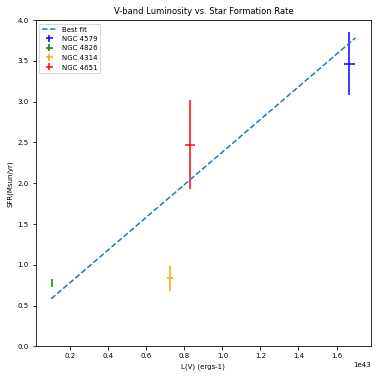

In [31]:
fig, ax = plt.subplots(figsize=(6,6))

M58plot = get_plot_values(M58photV, M58photH)
M64plot = get_plot_values(M64photV, M64photH)
NGC4314plot = get_plot_values(NGC4314photV, NGC4314photH)
NGC4651plot = get_plot_values(NGC4651photV, NGC4651photH)

def best_fit(x):
    return 2e-43*x + 0.3823

MW_lum = lum_to_ergs(1e10*u.Lsun)
MW_SFR = 2

ax.errorbar(M58plot[0], M58plot[1], yerr=M58plot[2], xerr = M58plot[3], fmt = 'none', color = 'blue', label = 'NGC 4579')
ax.errorbar(M64plot[0], M64plot[1], yerr=M64plot[2], xerr = M64plot[3], fmt = 'none', color = 'green', label = 'NGC 4826')
ax.errorbar(NGC4314plot[0], NGC4314plot[1], yerr=NGC4314plot[2], xerr = NGC4314plot[3], fmt = 'none', color = 'orange', label = 'NGC 4314')
ax.errorbar(NGC4651plot[0], NGC4651plot[1], yerr=NGC4651plot[2], xerr = NGC4651plot[3], fmt = 'none', color = 'red', label = 'NGC 4651')
#ax.scatter(MW_lum, MW_SFR)
x = np.linspace(1e42, 1.7e43, 100)
ax.plot(x,best_fit(x), linestyle='--', label = 'Best fit')
plt.title('V-band Luminosity vs. Star Formation Rate')
plt.ylabel('SFR(Msun/yr)')
plt.xlabel('L(V) (ergs-1)')

plt.ylim(0, 4)
plt.legend(loc=2)
plt.savefig('lumvsfr.png')

In [20]:
def BminusV(B,V):
    BV = B['absolute_magnitude'] - V['absolute_magnitude']
    error2 = B['magnitude_error']**2 + V['magnitude_error']**2
    error =  np.sqrt(error2)
    return BV, error

def SFR_over_L(H, V):
    SFR_over_L = H['star_formation_rate'].value/V['luminosity'].value
    error2 = SFR_over_L**2 * ((H['star_formation_rate_error'].value/H['star_formation_rate'].value)**2+(V['luminosity_error'].value/V['luminosity'].value)**2)
    error = np.sqrt(error2)
    return SFR_over_L, error

In [21]:
NGC4314_BminusV, NGC4314_BminusV_error = BminusV(NGC4314photB, NGC4314photV)
NGC4314_VminusR, NGC4314_VminusR_error = BminusV(NGC4314photV, NGC4314photR)
NGC4314_SFR, NGC4314_SFR_error = SFR_over_L(NGC4314photH, NGC4314photV)

NGC4651_VminusR, NGC4651_VminusR_error = BminusV(NGC4651photV, NGC4651photR)
NGC4651_SFR, NGC4651_SFR_error = SFR_over_L(NGC4651photH, NGC4651photV)

M58_BminusV, M58_BminusV_error = BminusV(M58photB, M58photV)
M58_VminusR, M58_VminusR_error = BminusV(M58photV, M58photR)
M58_SFR, M58_SFR_error = SFR_over_L(M58photH, M58photV)

M64_VminusR, M64_VminusR_error = BminusV(M64photV, M64photR)
M64_SFR, M64_SFR_error = SFR_over_L(M64photH, M64photV)

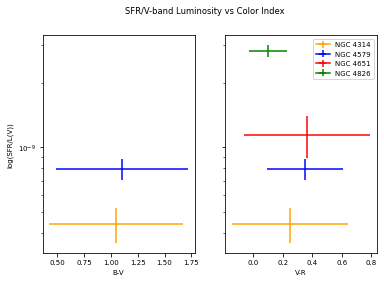

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
ax1.errorbar(NGC4314_BminusV, NGC4314_SFR, xerr=NGC4314_BminusV_error, yerr=NGC4314_SFR_error, color='orange', label='NGC 4314')
ax1.errorbar(M58_BminusV, M58_SFR, xerr=M58_BminusV_error, yerr=M58_SFR_error, color='blue', label='NGC 4579')
ax1.set_ylabel('log(SFR/L(V))')
ax1.set_xlabel('B-V')

ax2.errorbar(NGC4314_VminusR, NGC4314_SFR, xerr=NGC4314_VminusR_error, yerr=NGC4314_SFR_error, color='orange', label='NGC 4314')
ax2.errorbar(M58_VminusR, M58_SFR, xerr=M58_VminusR_error, yerr=M58_SFR_error, color='blue', label='NGC 4579')
ax2.errorbar(NGC4651_VminusR, NGC4651_SFR, xerr=NGC4651_VminusR_error, yerr=NGC4651_SFR_error, color='red', label='NGC 4651')
ax2.errorbar(M64_VminusR, M64_SFR, xerr=M64_VminusR_error, yerr=M64_SFR_error, color='green', label='NGC 4826')
ax2.set_xlabel('V-R')

plt.yscale('log')
plt.legend()
fig.suptitle('SFR/V-band Luminosity vs Color Index')
fig.savefig('sfrvbv.png');

In [24]:
def profile(data, geometry, bkg_annulus, N):
    #plt.imshow(_4314Rview, cmap='Greys', origin='lower')
    N = N
    x0, y0 = geometry.x0, geometry.y0
    result = np.zeros(N)
    radius = geometry.sma*(1-geometry.eps)
    center_aperture = CircularAperture((x0, y0),radius/N)
    bkg_phot = aperture_photometry(data, bkg_annulus)
    phot = aperture_photometry(data, center_aperture)
    result[0] = (phot['aperture_sum'].value - bkg_phot['aperture_sum'].value*center_aperture.area/bkg_annulus.area)/center_aperture.area
    #center_aperture.plot(color='green')
    #bkg_annulus.plot(color='red')
    
    for i in range(1, N):
        inner_radius = radius*i/N
        outer_radius = radius*(i+1)/N
        aper = CircularAnnulus((x0,y0), inner_radius, outer_radius)
        #aper.plot(color='green')
        phot = aperture_photometry(data, aper)
        result[i] = (phot['aperture_sum'].value - bkg_phot['aperture_sum'].value*aper.area/bkg_annulus.area)/aper.area
    return result

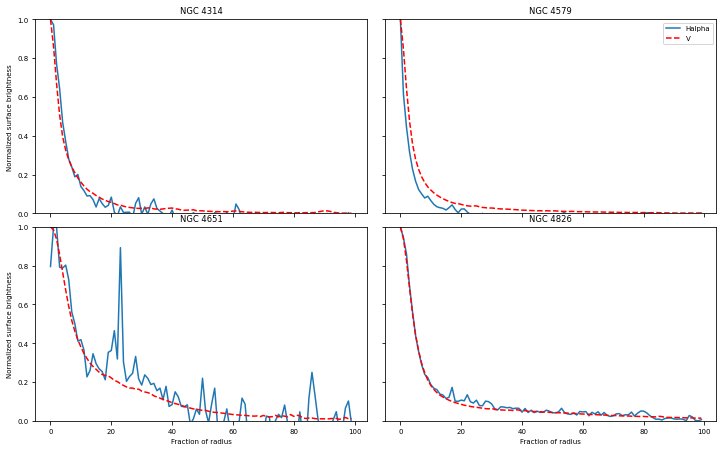

In [33]:
fig, ax = plt.subplots(2,2, figsize = (10,6), sharey=True, sharex=True)
plt.tight_layout()

NGC4314profileH = profile(NGC_4314_H, NGC4314geometry, NGC4314annulus, 100)
ax[0,0].plot(NGC4314profileH/max(NGC4314profileH), label='Halpha')
NGC4314profileR = profile(NGC_4314_R,NGC4314geometry, NGC4314annulus, 100)
ax[0,0].plot(NGC4314profileR/max(NGC4314profileR), linestyle='--', label='V', color='red')
ax[0,0].set_title('NGC 4314')
ax[0,0].set_ylabel('Normalized surface brightness')

M58profileH = profile(M58_H, M58geometry, M58annulus, 100)
ax[0,1].plot(M58profileH/max(M58profileH), label='Halpha')
M58profileR = profile(M58_R,M58geometry, M58annulus, 100)
ax[0,1].plot(M58profileR/max(M58profileR), linestyle='--', label='V', color='red')
ax[0,1].set_title('NGC 4579')

NGC4651profileH = profile(NGC_4651_H, NGC4651geometry, NGC4651annulus, 100)
ax[1,0].plot(NGC4651profileH/max(NGC4651profileH), label='Halpha')
NGC4651profileR = profile(NGC_4651_R,NGC4651geometry, NGC4651annulus, 100)
ax[1,0].plot(NGC4651profileR/max(NGC4651profileR), linestyle='--', label='V', color='red')
ax[1,0].set_title('NGC 4651')
ax[1,0].set_xlabel('Fraction of radius')
ax[1,0].set_ylabel('Normalized surface brightness')

M64profileH = profile(M64_H, M64geometry, M64annulus, 100)
ax[1,1].plot(M64profileH/max(M64profileH), label='Halpha')
M64profileR = profile(M64_R,M64geometry, M64annulus, 100)
ax[1,1].plot(M64profileR/max(M64profileR), linestyle='--', label='V', color='red')
ax[1,1].set_title('NGC 4826')
ax[1,1].set_xlabel('Fraction of radius')

ax[0,1].legend()

plt.ylim(0, 1)

plt.savefig('profile.png', bbox_inches='tight')

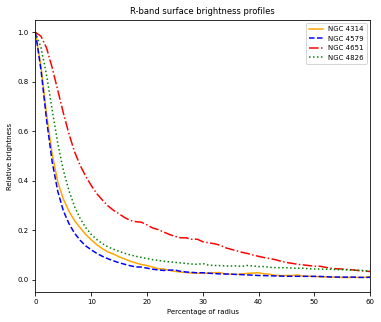

In [38]:
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(NGC4314profileR/max(NGC4314profileR), label='NGC 4314', color='orange')
ax.plot(M58profileR/max(M58profileR), linestyle='--', label='NGC 4579', color='blue')
ax.plot(NGC4651profileR/max(NGC4651profileR), linestyle='-.', label='NGC 4651', color='red')
ax.plot(M64profileR/max(M64profileR), linestyle=':', label='NGC 4826', color='green')
ax.set_xlim(0,60)
ax.set_title('R-band surface brightness profiles')
ax.set_xlabel('Percentage of radius')
ax.set_ylabel('Relative brightness')
plt.legend()
plt.savefig('comparativeprofile.png')
plt.show()